In [1]:
USE_GPU = True
from typing import List, Tuple, Dict, Any, Optional
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [2]:
import pandas as pd
import cudf
import numpy as np
import matplotlib.pyplot as plt


In [29]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
if USE_GPU:
    import cudf as gpu_pd
    import cuml
    import cupy as cp

    

In [4]:
USER_BIN_LIST_TIME = [
    (0, 60),
    (60, 120),
    (120, 180),
    
    (180, 240),
    (240, 360),
    (360, 480),
    
    (480, 600),
    (600, 720),
    (720, 840),
    
    (840, 1020),
    (1020, 1200),
    (1200, 1440),
    
    (1440, 1680),
    (1680, 3660),
    (3660, 7320),
    
    (7320, 14640),
    (14640, 29280),
    (29280, 1_000_000)
]

USER_BIN_LIST_SESSION = [
    (1, 2),
    (2, 5),
    (5, 10),
    
    (10, 15),
    (15, 20),
    (20, 25),
    
    (25, 30),
    (30, 40),
    (40, 50),
    
    (50, 60),
    (60, 80),
    (80, 100),
    
    (100, 150),
    (150, 200),
    (200, 500),
    
    (500, 1000),
    (1000, 2000)
]

In [5]:
def stats_by_user_bin_time(df, user_bin_list: List[Tuple[int, int]]):
    

    
    cols = [col for col in df.columns if 'seq' in col]
    sub_bin_matrix = []
    
    for bin in user_bin_list:
        print(f'Identifying users with between {bin[0]} and {bin[1]} total time')
        subset = df[(
            df['global_session_time'] >= bin[0]) & (df['global_session_time'] < bin[1])
        ].to_pandas()
        for col in cols:
            subset_class_col = subset[col].copy()
            count_user_sessions = subset[['user_id', 'session_30_raw']].drop_duplicates().shape[0]
            subset_class_col = subset_class_col.apply(lambda x: 1 if x > .5 else 0)
            bin_metrics = {
                    'bin': bin[1],
                    'count': count_user_sessions,
                    'model': col,
                    'acc': accuracy_score(subset['label'], subset_class_col),
                    'prec': precision_score(subset['label'], subset_class_col, zero_division=0),
                    'rec': recall_score(subset['label'], subset_class_col, zero_division=0),
                }
            try:
                bin_metrics['auc'] = roc_auc_score(subset['label'], subset[col])
            except ValueError:
                bin_metrics['auc'] = 0
            sub_bin_matrix.append(bin_metrics)
        
    return pd.DataFrame.from_records(sub_bin_matrix)        
        
        
def stats_by_user_bin_session(df, user_bin_list: List[Tuple[int, int]]):
    max_session_events = df.groupby('user_id').agg({'session_30_raw': 'max'}).reset_index().rename(columns={'session_30_raw': 'session_30_max'})
    df = df.merge(max_session_events, on='user_id', how='left')

    max_session_event_unique = max_session_events['session_30_max'].unique()
    cols = [col for col in df.columns if 'seq' in col]
    sub_bin_matrix = []
    
    for bin in user_bin_list:
        print(f'Identifying users with between {bin[0]} and {bin[1]} total sessions')
        subset = df[(
            df['session_30_max'] >= bin[0]) & (df['session_30_max'] < bin[1])
        ].to_pandas()
        
        for col in cols:
            subset_class_col = subset[col].copy()
            count_user_sessions = subset[['user_id', 'session_30_raw']].drop_duplicates().shape[0]
            subset_class_col = subset_class_col.apply(lambda x: 1 if x > .5 else 0)
            bin_metrics = {
                    'bin': bin[1],
                    'count': count_user_sessions,
                    'model': col,
                    'acc': accuracy_score(subset['label'], subset_class_col),
                    'prec': precision_score(subset['label'], subset_class_col, zero_division=0),
                    'rec': recall_score(subset['label'], subset_class_col, zero_division=0),
                }
            try:
                bin_metrics['auc'] = roc_auc_score(subset['label'], subset[col])
            except ValueError:
                bin_metrics['auc'] = 0
            sub_bin_matrix.append(bin_metrics)
                                            
            
        
    return pd.DataFrame.from_records(sub_bin_matrix)







In [6]:
print(f'Loading data')
df = cudf.read_parquet('rl_ready_data/files_used_30/predicted_data.parquet')
print('Data loaded')

Loading data
Data loaded


In [7]:
df = df.rename(columns={'continue_work_session_30_minutes': 'label'})

In [8]:
eval_df_param, test_df_param = (
    (int(df.shape[0] * .7), int(df.shape[0] * .85)),
    (int(df.shape[0] * .85), df.shape[0])
)

eval_df = df.iloc[eval_df_param[0]:eval_df_param[1]]
test_df = df.iloc[test_df_param[0]:test_df_param[1]]

In [9]:
user_time_stats_eval = stats_by_user_bin_time(eval_df, USER_BIN_LIST_TIME)
user_time_stats_eval.to_csv('lstm_metrics/eval_time_30.csv', index=False)

user_time_stats_test = stats_by_user_bin_time(test_df, USER_BIN_LIST_TIME)
user_time_stats_test.to_csv('lstm_metrics/test_time_30.csv', index=False)


Identifying users with between 0 and 60 total time
Identifying users with between 60 and 120 total time
Identifying users with between 120 and 180 total time
Identifying users with between 180 and 240 total time
Identifying users with between 240 and 360 total time
Identifying users with between 360 and 480 total time
Identifying users with between 480 and 600 total time
Identifying users with between 600 and 720 total time
Identifying users with between 720 and 840 total time
Identifying users with between 840 and 1020 total time
Identifying users with between 1020 and 1200 total time
Identifying users with between 1200 and 1440 total time
Identifying users with between 1440 and 1680 total time
Identifying users with between 1680 and 3660 total time
Identifying users with between 3660 and 7320 total time
Identifying users with between 7320 and 14640 total time
Identifying users with between 14640 and 29280 total time
Identifying users with between 29280 and 1000000 total time
Identify

In [10]:
user_time_stats_eval.head()

,bin,count,model,acc,prec,rec,auc
0,60,108,seq_1,0.998915,0.0,0.0,0.412147
1,60,108,seq_10,0.998915,0.0,0.0,0.603302
2,60,108,seq_20,0.998915,0.0,0.0,0.491027
3,60,108,seq_30,0.998915,0.0,0.0,0.386728
4,60,108,seq_30_heuristic,0.998915,0.0,0.0,0.427297


In [11]:
user_bin_stats_eval = stats_by_user_bin_session(eval_df, USER_BIN_LIST_SESSION)
user_bin_stats_eval.to_csv('lstm_metrics/eval_session_30.csv', index=False)

user_bin_stats_test = stats_by_user_bin_session(test_df, USER_BIN_LIST_SESSION)
user_bin_stats_test.to_csv('lstm_metrics/test_session_30.csv', index=False)

Identifying users with between 1 and 2 total sessions
Identifying users with between 2 and 5 total sessions
Identifying users with between 5 and 10 total sessions
Identifying users with between 10 and 15 total sessions
Identifying users with between 15 and 20 total sessions
Identifying users with between 20 and 25 total sessions


/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt

Identifying users with between 25 and 30 total sessions
Identifying users with between 30 and 40 total sessions
Identifying users with between 40 and 50 total sessions
Identifying users with between 50 and 60 total sessions
Identifying users with between 60 and 80 total sessions
Identifying users with between 80 and 100 total sessions
Identifying users with between 100 and 150 total sessions
Identifying users with between 150 and 200 total sessions
Identifying users with between 200 and 500 total sessions
Identifying users with between 500 and 1000 total sessions
Identifying users with between 1000 and 2000 total sessions
Identifying users with between 1 and 2 total sessions
Identifying users with between 2 and 5 total sessions
Identifying users with between 5 and 10 total sessions
Identifying users with between 10 and 15 total sessions
Identifying users with between 15 and 20 total sessions
Identifying users with between 20 and 25 total sessions
Identifying users with between 25 and 3

/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/envs/rapids/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt

Identifying users with between 30 and 40 total sessions
Identifying users with between 40 and 50 total sessions
Identifying users with between 50 and 60 total sessions
Identifying users with between 60 and 80 total sessions
Identifying users with between 80 and 100 total sessions
Identifying users with between 100 and 150 total sessions
Identifying users with between 150 and 200 total sessions
Identifying users with between 200 and 500 total sessions
Identifying users with between 500 and 1000 total sessions
Identifying users with between 1000 and 2000 total sessions


In [12]:
eval_session, eval_time, test_session, test_time = (
    pd.read_csv('lstm_metrics/eval_session_30.csv'),
    pd.read_csv('lstm_metrics/eval_time_30.csv'), 
    pd.read_csv('lstm_metrics/test_session_30.csv'),
    pd.read_csv('lstm_metrics/test_time_30.csv')
)

[Text(0.5, 190.7222222222222, 'Cumulative Platform Time'),
 Text(1058.0517676767674, 0.5, 'AUC'),
 Text(0.5, 1.0, 'Test AUC | Platform Time')]

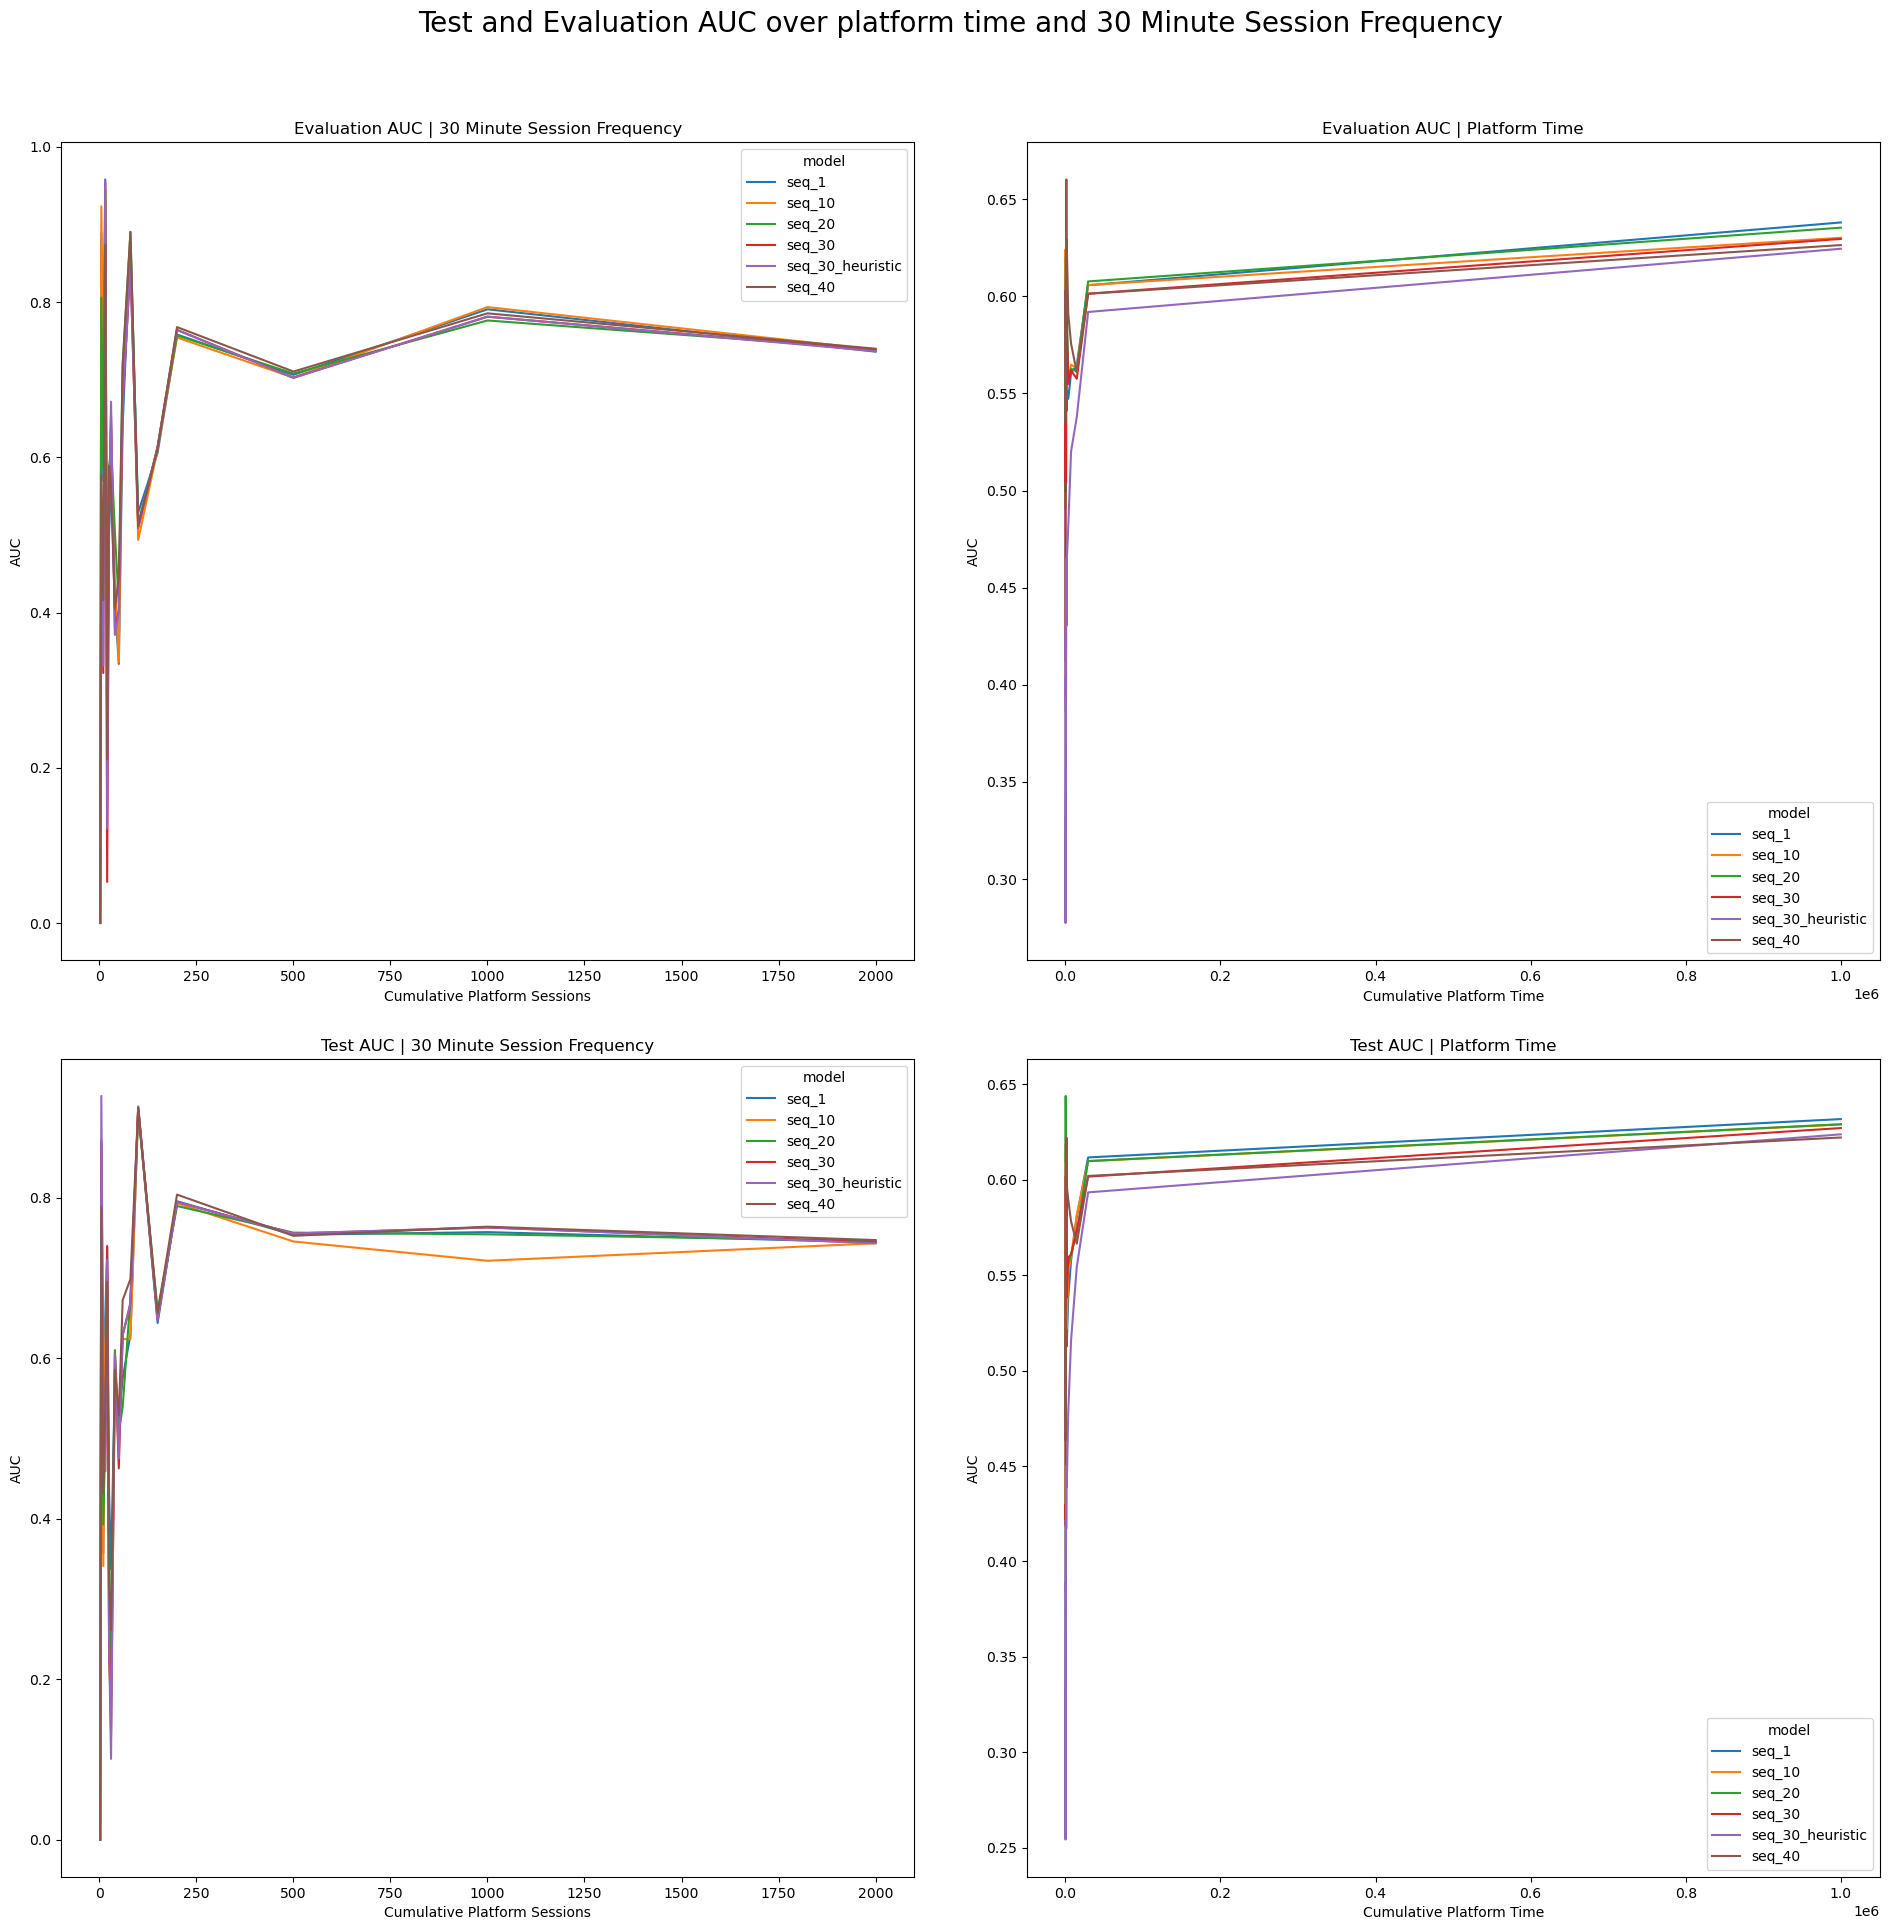

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

fig.suptitle('Test and Evaluation AUC over platform time and 30 Minute Session Frequency', fontsize=20)
plt.tight_layout(pad=5.0)
ax = ax.flatten()
eval_session_plt = sns.lineplot(x='bin', y='auc', data=eval_session, hue='model', ax=ax[0])
eval_session_plt.set(xlabel='Cumulative Platform Sessions', ylabel='AUC', title='Evaluation AUC | 30 Minute Session Frequency')

eval_time_plt = sns.lineplot(x='bin', y='auc', data=eval_time, hue='model', ax=ax[1])
eval_time_plt.set(xlabel='Cumulative Platform Time', ylabel='AUC', title='Evaluation AUC | Platform Time')

test_session_plt = sns.lineplot(x='bin', y='auc', data=test_session, hue='model', ax=ax[2])
test_session_plt.set(xlabel='Cumulative Platform Sessions', ylabel='AUC', title='Test AUC | 30 Minute Session Frequency')

test_time_plt = sns.lineplot(x='bin', y='auc', data=test_time, hue='model', ax=ax[3])
test_time_plt.set(xlabel='Cumulative Platform Time', ylabel='AUC', title='Test AUC | Platform Time')

[Text(0.5, 190.7222222222222, 'cumulative platform time'),
 Text(1058.0517676767674, 0.5, 'AUC'),
 Text(0.5, 1.0, 'Test AUC over cumulative time')]

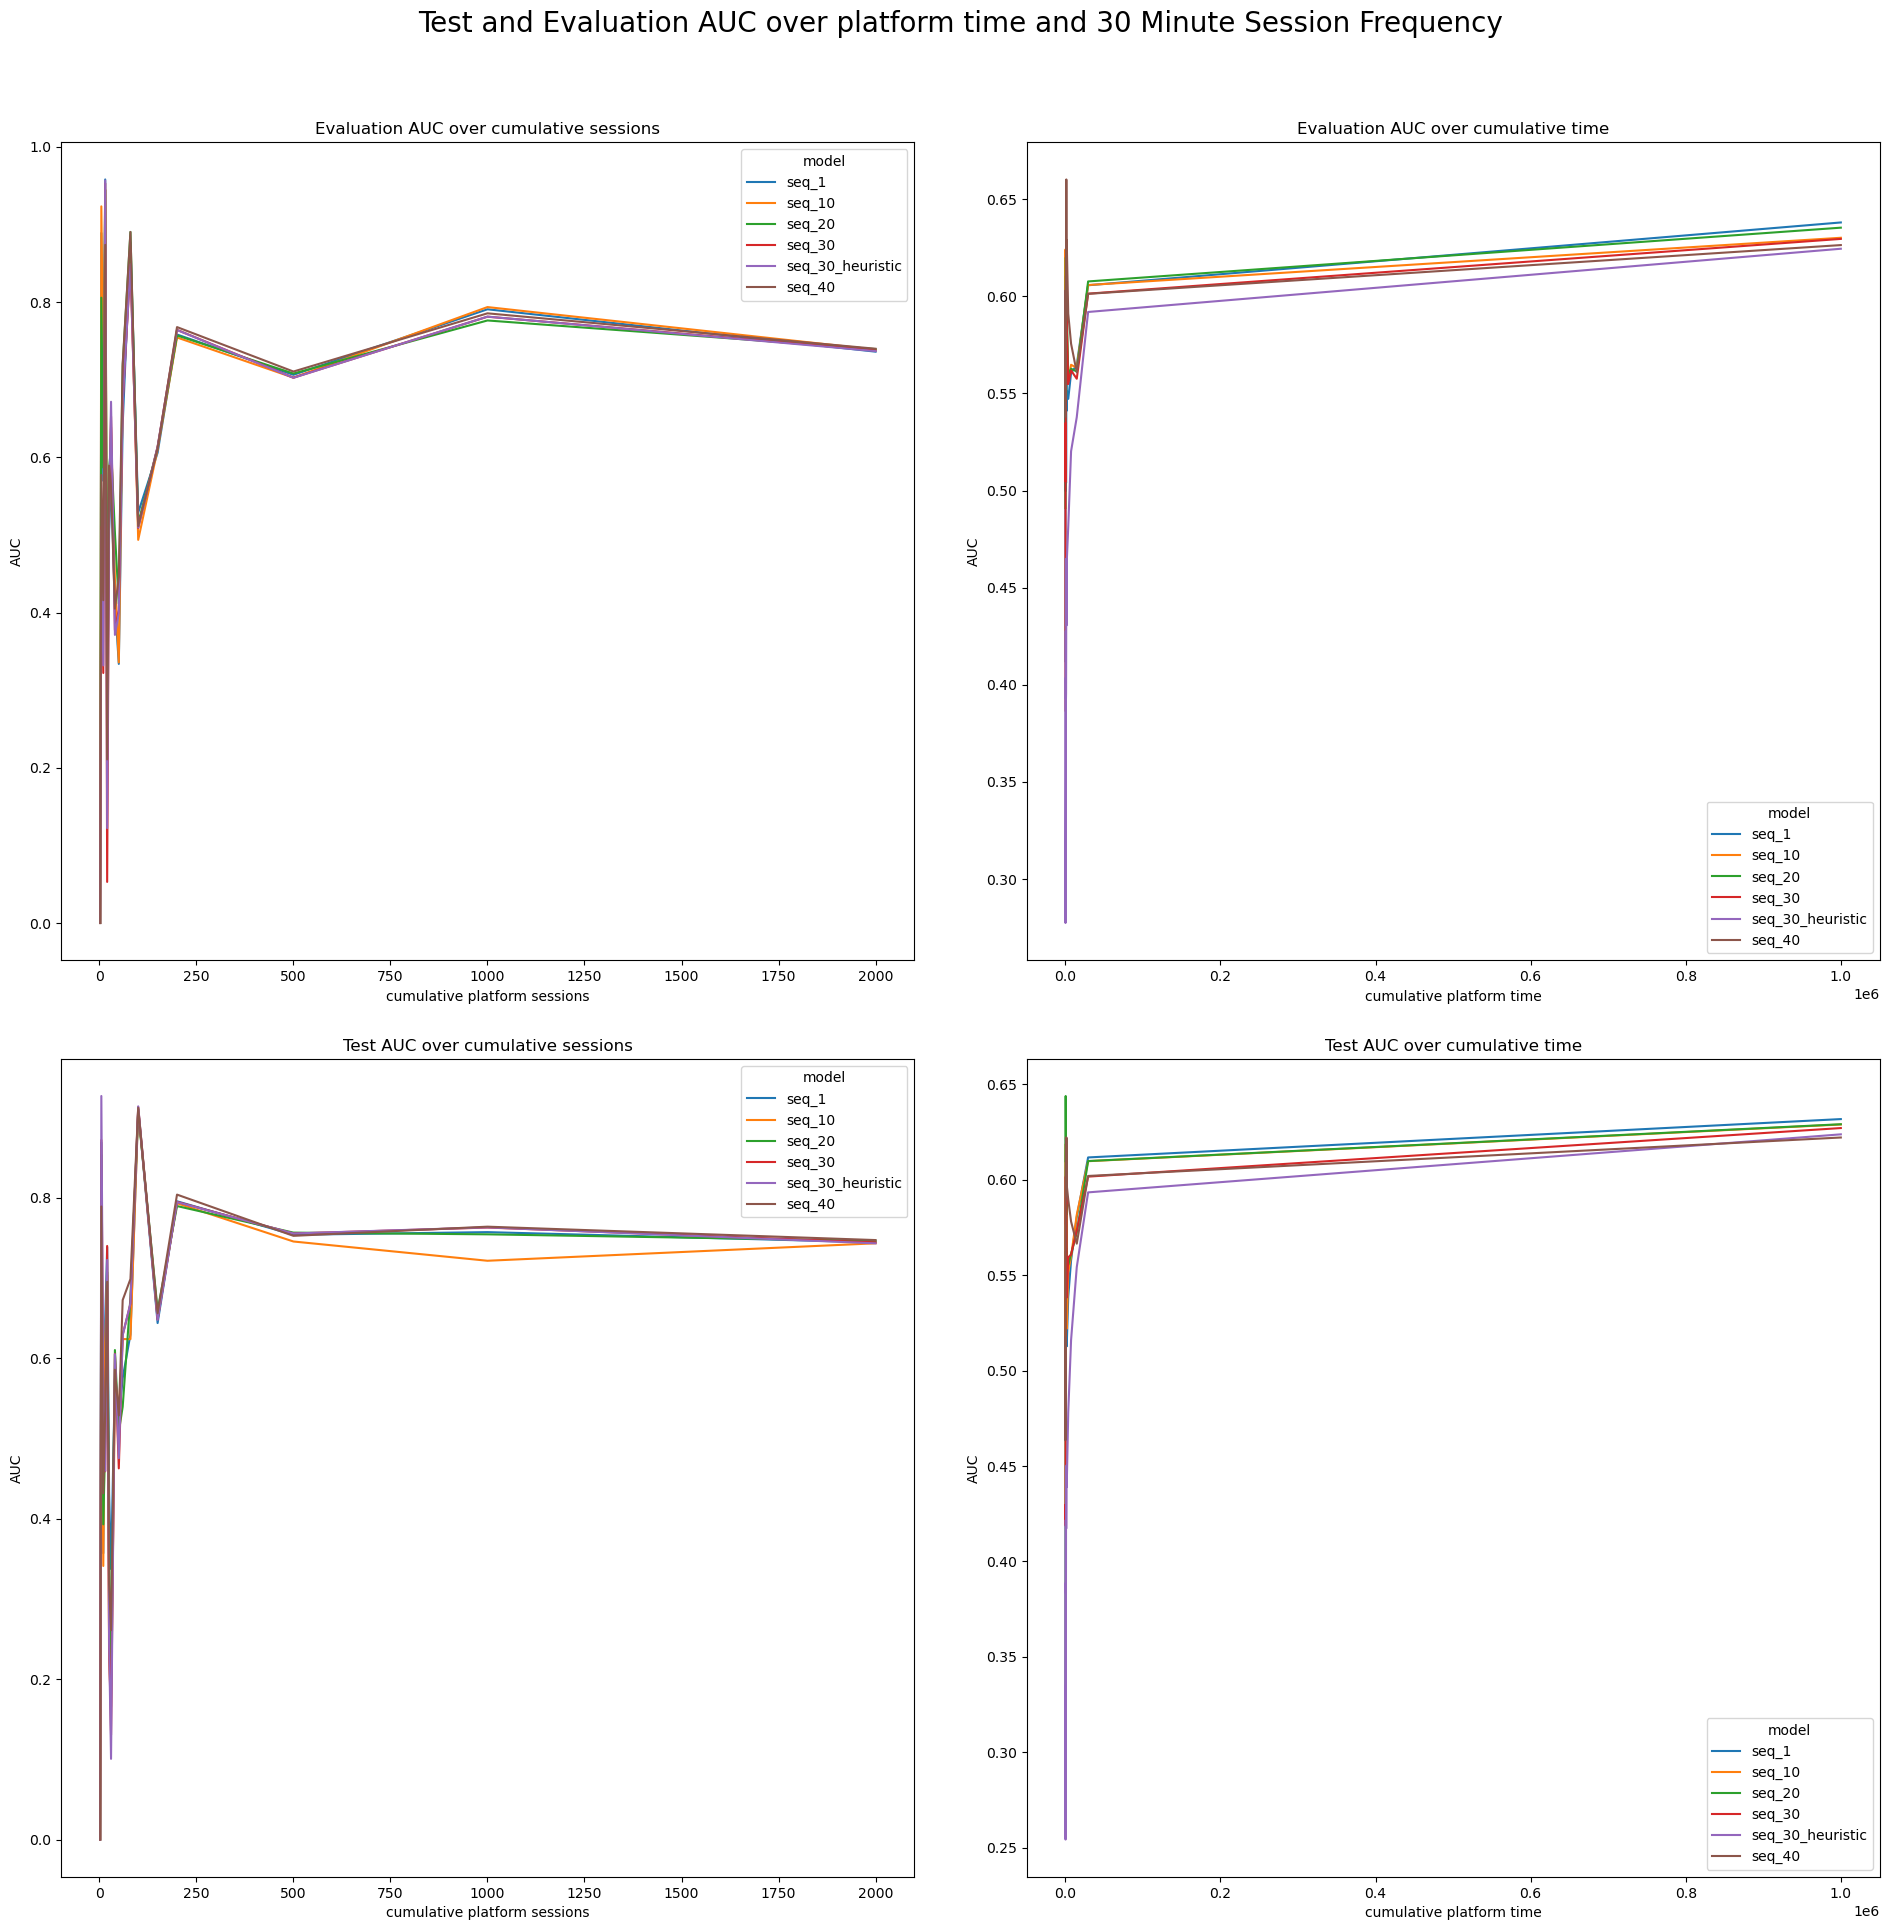

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

fig.suptitle('Test and Evaluation AUC over platform time and 30 Minute Session Frequency', fontsize=20)
plt.tight_layout(pad=5.0)
ax = ax.flatten()
eval_session_plt = sns.lineplot(x='bin', y='auc', data=eval_session, hue='model', ax=ax[0])
eval_session_plt.set(xlabel='cumulative platform sessions', ylabel='AUC', title='Evaluation AUC over cumulative sessions')

eval_time_plt = sns.lineplot(x='bin', y='auc', data=eval_time, hue='model', ax=ax[1])
eval_time_plt.set(xlabel='cumulative platform time', ylabel='AUC', title='Evaluation AUC over cumulative time')

test_session_plt = sns.lineplot(x='bin', y='auc', data=test_session, hue='model', ax=ax[2])
test_session_plt.set(xlabel='cumulative platform sessions', ylabel='AUC', title='Test AUC over cumulative sessions')

test_time_plt = sns.lineplot(x='bin', y='auc', data=test_time, hue='model', ax=ax[3])
test_time_plt.set(xlabel='cumulative platform time', ylabel='AUC', title='Test AUC over cumulative time')

In [36]:
eval_time[eval_time['bin'] == 120]

,bin,count,model,acc,prec,rec,auc
6,120,44,seq_1,0.989,0.000,0.000,0.555
7,120,44,seq_10,0.989,0.000,0.000,0.606
8,120,44,seq_20,0.989,0.000,0.000,0.518
9,120,44,seq_30,0.989,0.000,0.000,0.535
10,120,44,seq_30_heuristic,0.989,0.000,0.000,0.277
11,120,44,seq_40,0.989,0.000,0.000,0.603


In [38]:
eval_time[eval_time['bin'] == 1_000_000]

,bin,count,model,acc,prec,rec,auc
102,1000000,1809,seq_1,0.670,0.486,0.173,0.638
103,1000000,1809,seq_10,0.663,0.460,0.174,0.630
104,1000000,1809,seq_20,0.671,0.492,0.177,0.635
105,1000000,1809,seq_30,0.667,0.474,0.162,0.630
106,1000000,1809,seq_30_heuristic,0.667,0.473,0.162,0.625
107,1000000,1809,seq_40,0.669,0.480,0.159,0.626


In [15]:
time_bins = [i[1] for i in USER_BIN_LIST_TIME]

In [16]:
bin_df = pd.DataFrame(time_bins, columns=['global_session_time'])
bin_df['global_session_time'] = bin_df['global_session_time']
bin_df['bin'] = bin_df['global_session_time']

In [30]:
eval_df_session_bars = eval_df[['label', 'global_session_time'] + [col for col in eval_df.columns if 'seq' in col]].dropna()
eval_df_session_bars['global_session_time'] = eval_df_session_bars['global_session_time'].astype(int)
eval_df_session_bars = eval_df_session_bars.to_pandas()
eval_df_session_bars_merged = pd.merge_asof(eval_df_session_bars.sort_values('global_session_time'), bin_df.sort_values('global_session_time'), on='global_session_time', direction='backward')
eval_df_session_bars_merged['label']
eval_df_session_bars_merged['label_count'] = eval_df_session_bars_merged['label']
eval_df_session_bars_merged['bin'] = eval_df_session_bars_merged['bin'].fillna(60)

for col in [col for col in eval_df_session_bars_merged.columns if 'seq' in col]:
    eval_df_session_bars_merged[col] = eval_df_session_bars_merged[col].apply(lambda x: 0 if x < 0.5 else 1)

eval_df_session_bars_merged = eval_df_session_bars_merged.drop(columns=['global_session_time'])

eval_time_grouper = eval_df_session_bars_merged.groupby('bin').agg({
    'label_count': 'count',
    'label': 'sum',
    'seq_1': 'sum',
    'seq_20': 'sum',
    'seq_30': 'sum', 
    'seq_30_heuristic': 'sum',
    'seq_40': 'sum',
}).reset_index()

eval_time_grouper['perc'] = 1 - (eval_time_grouper['label'] / eval_time_grouper['label_count'])
for col in [col for col in eval_time_grouper.columns if 'seq' in col]:
    eval_time_grouper[f'{col}_perc'] = 1 - (eval_time_grouper[col] / eval_time_grouper['label_count'])
eval_time_grouper.to_csv('lstm_metrics/eval_time_grouper.csv', index=False)
eval_time_grouper

,bin,label_count,label,seq_1,seq_20,seq_30,seq_30_heuristic,seq_40,perc,seq_1_perc,seq_20_perc,seq_30_perc,seq_30_heuristic_perc,seq_40_perc
0,60.000,50575,250.000,0,0,0,0,0,0.995,1.000,1.000,1.000,1.000,1.000
1,120.000,17300,314.000,1,0,0,0,2,0.982,1.000,1.000,1.000,1.000,1.000
2,180.000,14875,465.000,2,0,2,0,2,0.969,1.000,1.000,1.000,1.000,1.000
3,240.000,28835,1401.000,13,0,3,1,3,0.951,1.000,1.000,1.000,1.000,1.000
4,360.000,27587,1309.000,54,10,0,1,5,0.953,0.998,1.000,1.000,1.000,1.000
5,480.000,23656,1391.000,37,21,7,6,12,0.941,0.998,0.999,1.000,1.000,0.999
6,600.000,22513,1726.000,36,18,3,6,18,0.923,0.998,0.999,1.000,1.000,0.999
7,720.000,19665,1844.000,88,100,51,57,60,0.906,0.996,0.995,0.997,0.997,0.997
8,840.000,30618,2972.000,87,50,19,16,40,0.903,0.997,0.998,0.999,0.999,0.999
9,1020.000,29319,2975.000,103,50,41,41,86,0.899,0.996,0.998,0.999,0.999,0.997


In [31]:
test_df_session_bars = test_df[['label', 'global_session_time'] + [col for col in test_df.columns if 'seq' in col]].dropna()
test_df_session_bars['global_session_time'] = test_df_session_bars['global_session_time'].astype(int)
test_df_session_bars = test_df_session_bars.to_pandas()
test_df_session_bars_merged = pd.merge_asof(test_df_session_bars.sort_values('global_session_time'), bin_df.sort_values('global_session_time'), on='global_session_time', direction='backward')
test_df_session_bars_merged['label']
test_df_session_bars_merged['label_count'] = test_df_session_bars_merged['label']
test_df_session_bars_merged['bin'] = test_df_session_bars_merged['bin'].fillna(60)

for col in [col for col in test_df_session_bars_merged.columns if 'seq' in col]:
    test_df_session_bars_merged[col] = test_df_session_bars_merged[col].apply(lambda x: 0 if x < 0.5 else 1)

test_df_session_bars_merged = test_df_session_bars_merged.drop(columns=['global_session_time'])

test_time_grouper = test_df_session_bars_merged.groupby('bin').agg({
    'label_count': 'count',
    'label': 'sum',
    'seq_1': 'sum',
    'seq_20': 'sum',
    'seq_30': 'sum', 
    'seq_30_heuristic': 'sum',
    'seq_40': 'sum',
}).reset_index()

test_time_grouper['perc_base'] = 1 - (test_time_grouper['label'] / test_time_grouper['label_count'])
for col in [col for col in test_time_grouper.columns if 'seq' in col]:
    test_time_grouper[f'{col}_perc'] = 1 - (test_time_grouper[col] / test_time_grouper['label_count'])
test_time_grouper.to_csv('lstm_metrics/test_time_grouper.csv', index=False)
test_time_grouper

,bin,label_count,label,seq_1,seq_20,seq_30,seq_30_heuristic,seq_40,perc_base,seq_1_perc,seq_20_perc,seq_30_perc,seq_30_heuristic_perc,seq_40_perc
0,60.000,40834,224.000,1,0,0,0,2,0.995,1.000,1.000,1.000,1.000,1.000
1,120.000,14332,295.000,1,0,0,0,0,0.979,1.000,1.000,1.000,1.000,1.000
2,180.000,14365,402.000,0,0,0,0,3,0.972,1.000,1.000,1.000,1.000,1.000
3,240.000,25640,991.000,17,3,4,4,1,0.961,0.999,1.000,1.000,1.000,1.000
4,360.000,21125,1059.000,13,1,2,2,7,0.950,0.999,1.000,1.000,1.000,1.000
5,480.000,21196,1415.000,42,24,13,13,11,0.933,0.998,0.999,0.999,0.999,0.999
6,600.000,20238,1398.000,30,11,6,8,10,0.931,0.999,0.999,1.000,1.000,1.000
7,720.000,16027,1544.000,45,24,9,11,23,0.904,0.997,0.999,0.999,0.999,0.999
8,840.000,24261,2725.000,146,139,56,56,77,0.888,0.994,0.994,0.998,0.998,0.997
9,1020.000,20763,2492.000,145,105,68,57,107,0.880,0.993,0.995,0.997,0.997,0.995


In [ ]:
print()